# In-between uncertainty

In [1]:
import jax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
import matplotlib.pyplot as plt

In [2]:
from rebayes_mini.methods import low_rank_last_layer as l3rfilter

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [6]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [7]:
qlow = 0.25
qhigh = 0.75

## Test function

In [8]:
def sample_fn(key, n_samples, noise=0.1):
    key_W, key_b, key_x, key_y = jax.random.split(key, 4)


    W = jax.random.normal(key_W, (30, 1))
    b = jax.random.normal(key_b, (30, 1)) * 2 * jnp.pi * 0.0

    x1, x2 = jax.random.normal(key_x, (2, n_samples))
    y_err = jax.random.normal(key_y, n_samples)
    
    x = 5 * jnp.sign(x1) + x2.clip(-2, 2)
    y = jnp.cos(W * x + b).sum(axis=0) / 2.0 + noise * y_err

    return x / 10,  y

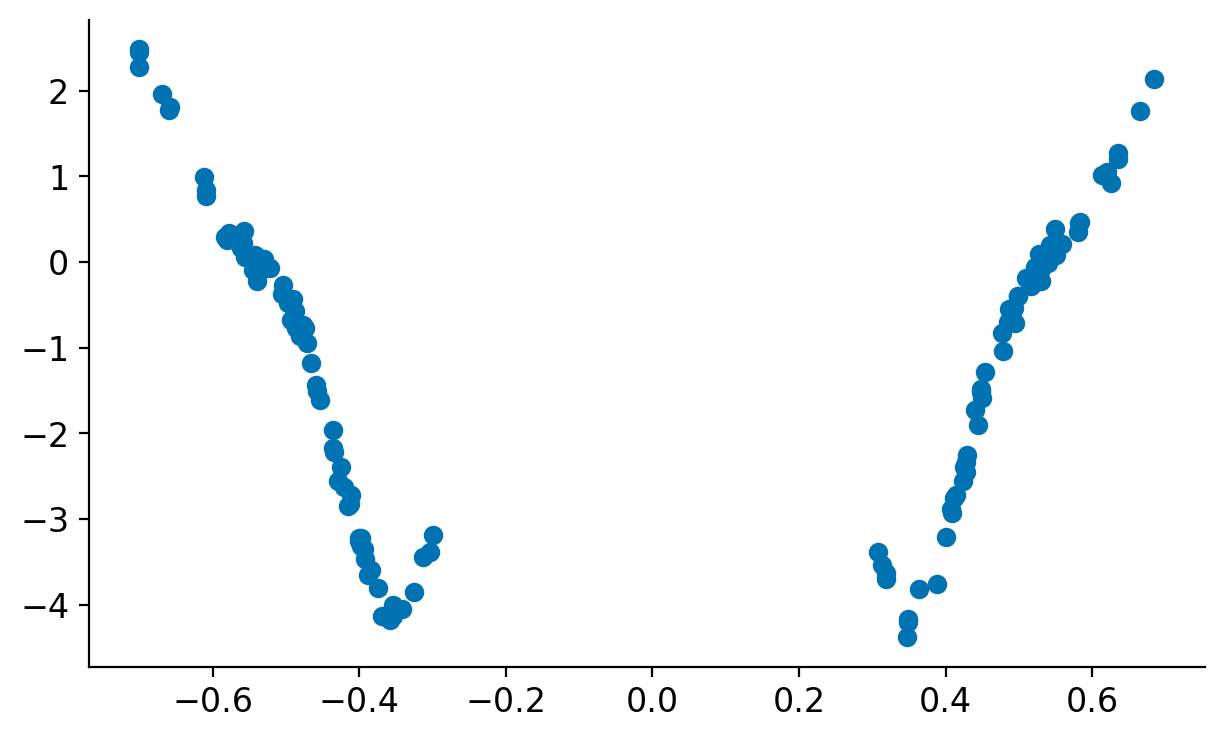

In [9]:
key = jax.random.PRNGKey(3)
key_sample, key_train = jax.random.split(key)

n_samples = 128

xrange = jnp.linspace(-0.8, 0.8, 200)
x_samples, y_samples = sample_fn(key_sample, n_samples)
plt.scatter(x_samples, y_samples)

## Single-pass LL-LRKF

In [78]:
class MLP(nn.Module):
    n_hidden: int = 128

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [79]:
key_init_params, key_hidden, key_last = jax.random.split(key_train, 3)

In [91]:
%%time
model = MLP()
params_init = model.init(key_init_params, x_samples[:, None])

def cov_fn(y): return 0.1 ** 2
agent = l3rfilter.LowRankLastLayer(
    model.apply, cov_fn, dynamics_hidden=0.0, dynamics_last=0.0, rank=50,
)

cov_hidden = 0.4
cov_last = 0.7
bel_init = agent.init_bel(
    params_init, cov_hidden=cov_hidden, cov_last=cov_last, low_rank_diag=False
)


bel_init = bel_init.replace(
    mean_hidden=cov_hidden * jax.random.normal(key_hidden, (len(bel_init.mean_hidden)),),
    mean_last=cov_last*jax.random.normal(key_hidden, (len(bel_init.mean_last)),),
)
bel, _ = agent.scan(bel_init, y_samples, x_samples[:, None])
bel = jax.block_until_ready(bel)

CPU times: user 2.92 s, sys: 124 ms, total: 3.04 s
Wall time: 949 ms


In [92]:
@jax.vmap
def ppvar(x):
    Ht = agent.jac_last(bel.mean_hidden, bel.mean_last, x)
    return  Ht @ bel.loading_last.T @ bel.loading_last @ Ht.T + cov_fn(1.0)

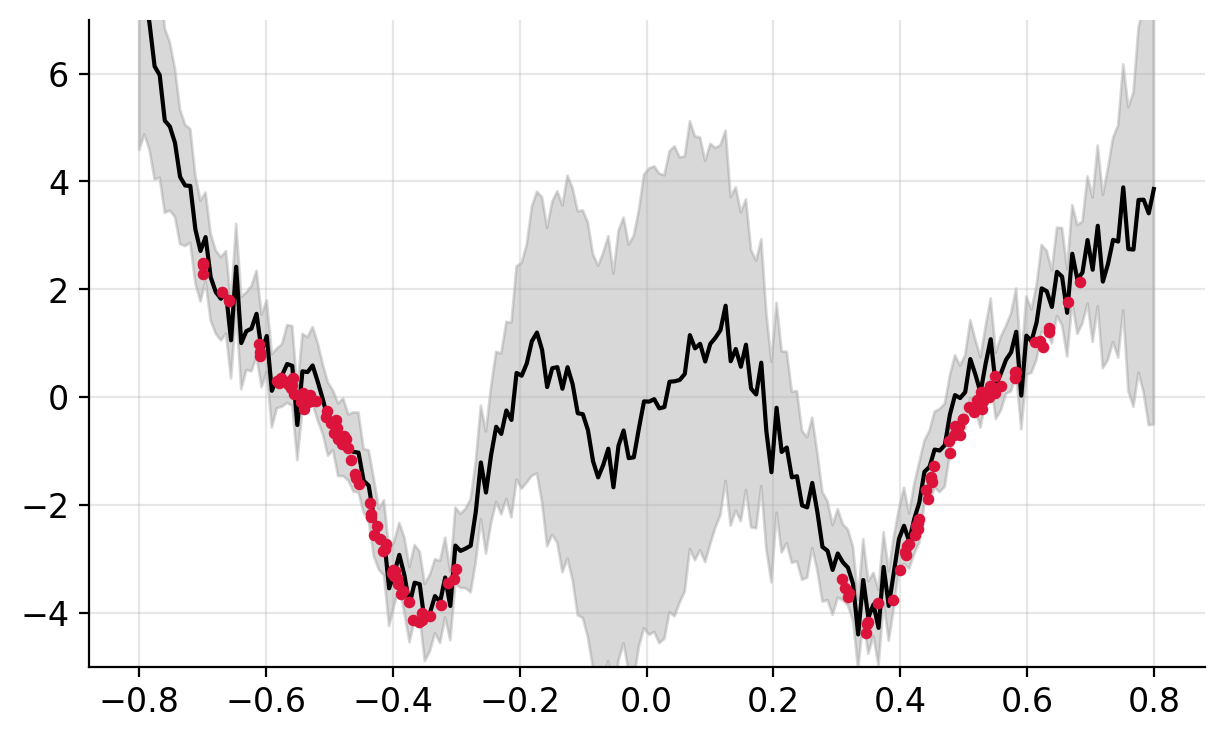

In [93]:
pvar_x = jnp.sqrt(ppvar(xrange[:, None]).squeeze())
pmean_x = agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]).squeeze()

plt.fill_between(xrange, pmean_x - 2 * pvar_x, pmean_x + 2  *  pvar_x, color="gray", alpha=0.3)
plt.plot(xrange, pmean_x, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.ylim(-5, 7)
plt.grid(alpha=0.3)

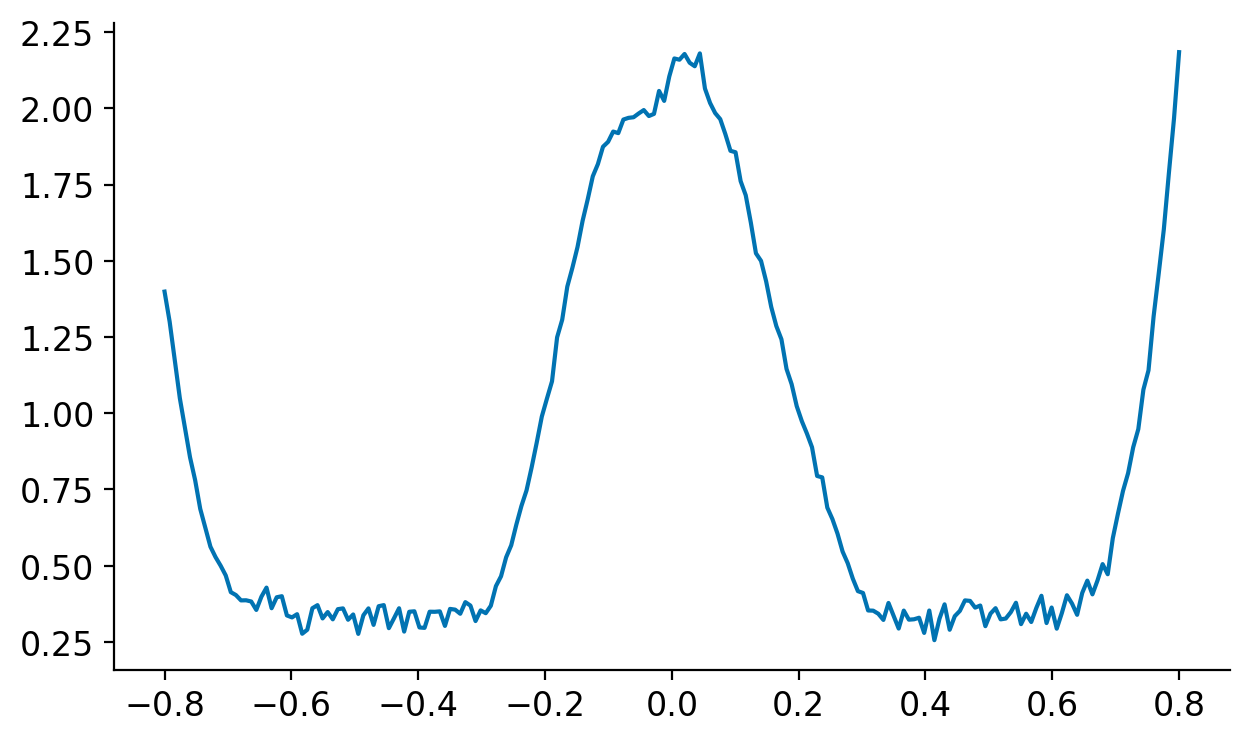

In [94]:
plt.plot(xrange, pvar_x)

## Coupling with GPs

In [16]:
params_final = agent.rfn(jnp.r_[bel.mean_hidden, bel.mean_last])

In [17]:
X_enc = model.apply(params_final, x_samples[:, None], method=MLP.encode)
Xtest_enc = model.apply(params_final, xrange[:, None], method=MLP.encode)

In [18]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def kgauss(u, v, gamma2=1.0):
    return jnp.exp(-jnp.linalg.norm(u - v) ** 2 / (2 * gamma2))

In [19]:
gamma2 = 0.5 ** 2
var_train = kgauss(X_enc, X_enc, gamma2)
cov_test_train = kgauss(Xtest_enc, X_enc, gamma2)
var_test = kgauss(Xtest_enc, Xtest_enc, gamma2)

In [20]:
K = jnp.linalg.solve(var_train + 0.05 ** 2 * jnp.eye(n_samples), cov_test_train.T).T
mu_pred = K @ y_samples

In [21]:
sigma_pred = var_test - K @ var_train @ K.T
sigma_diag = jnp.diag(sigma_pred)

lbound = mu_pred - 2 * sigma_diag
ubound = mu_pred + 2 * sigma_diag

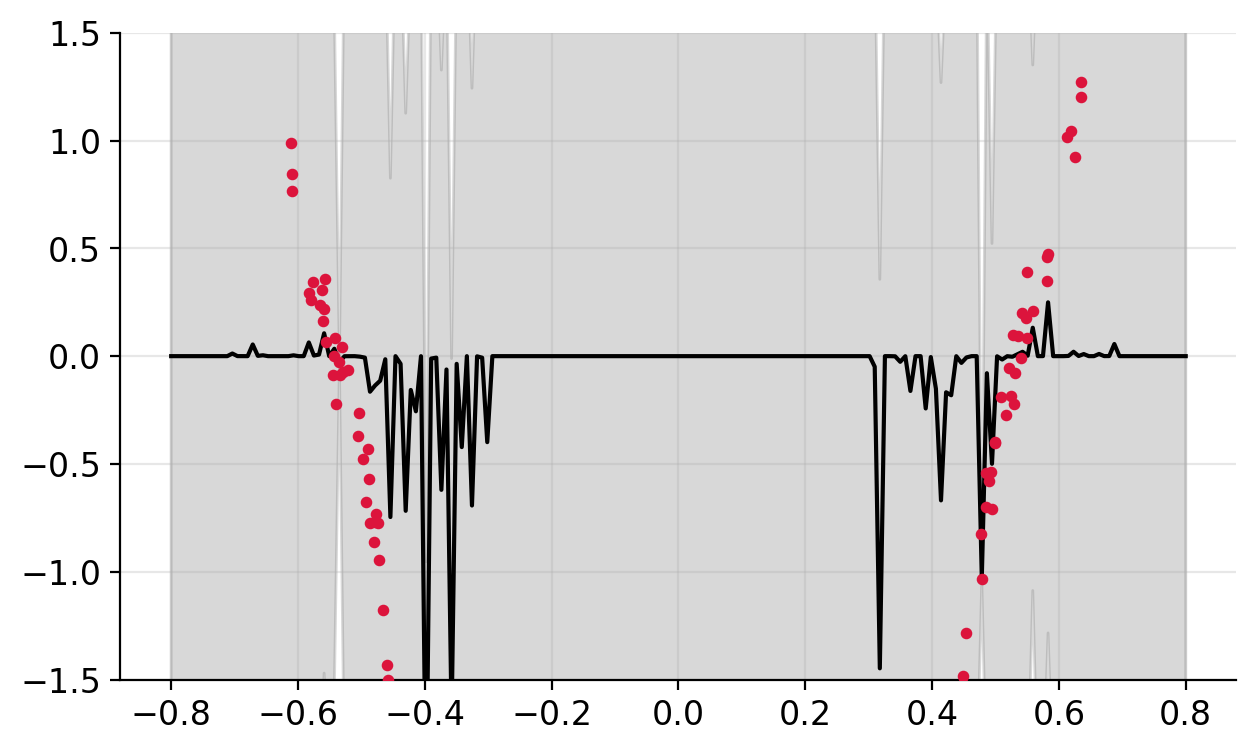

In [22]:
plt.plot(xrange, mu_pred, color="black")
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)

plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.ylim(-1.5, 1.5)
plt.grid(alpha=0.3)

# Last-layer methods

In [23]:
import optax
from flax.training.train_state import TrainState
from vbll.jax.layers import Regression

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MLP

In [24]:
mlp = MLP()
params_init = model.init(key_train, x_samples[:, None])
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (128,), 'kernel': (1, 128)},
  'Dense_1': {'bias': (128,), 'kernel': (128, 128)},
  'Dense_2': {'bias': (128,), 'kernel': (128, 128)},
  'Dense_3': {'bias': (128,), 'kernel': (128, 128)},
  'last_layer': {'bias': (1,), 'kernel': (128, 1)}}}

In [25]:
@jax.value_and_grad
def eval_grads(params):
    yhat = mlp.apply(params, x_samples[:, None]).squeeze()
    errs = jnp.power(yhat - y_samples, 2)
    return errs.mean()

In [26]:
state = TrainState.create(
    apply_fn=eval_grads,
    params=params_init,
    tx=optax.adamw(1e-3)
)

In [27]:
def step(state, _):
    loss, grads = state.apply_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [28]:
n_epochs = 2000
epochs = jnp.arange(n_epochs)
state_final, losses = jax.lax.scan(step, state, epochs)

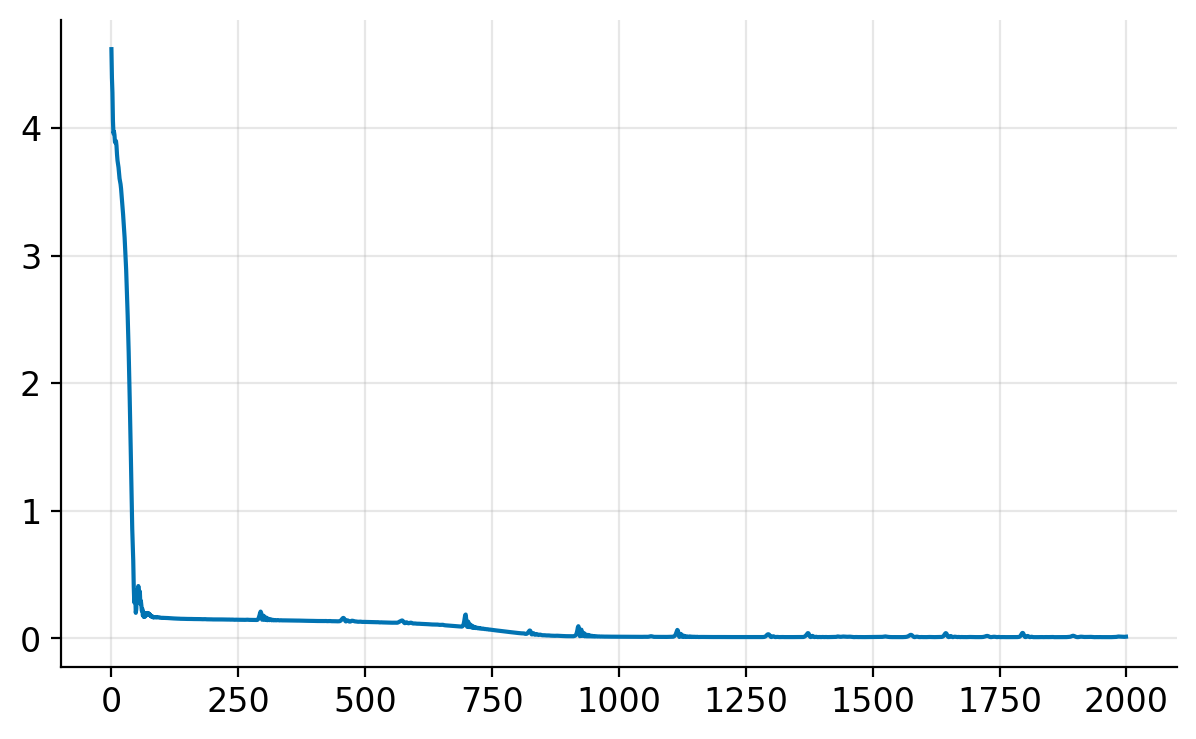

In [29]:
plt.plot(losses)
plt.grid(alpha=0.3)
# plt.yscale("log")

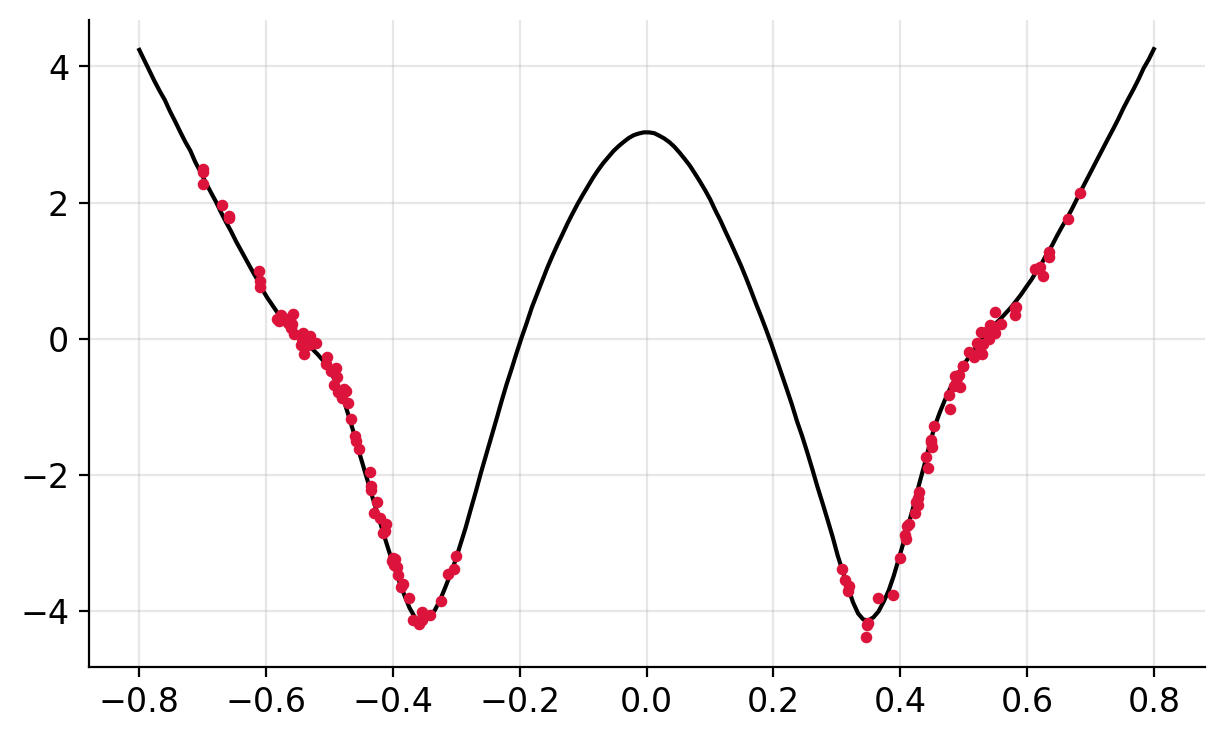

In [30]:
yhat = mlp.apply(state_final.params, xrange[:, None])
plt.plot(xrange, yhat, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.grid(alpha=0.3)

## VBLL

Sources:
1. [Notebook example in Pytorch](https://colab.research.google.com/github/VectorInstitute/vbll/blob/main/docs/tutorials/VBLL_Regression.ipynb#scrollTo=dOUWXc9HLI0T)
2. [Regression layer definition](https://github.com/VectorInstitute/vbll/blob/main/vbll/jax/layers/regression.py)

In [31]:
class VBLLMLP(nn.Module):
    n_hidden: int = 64

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=0.1,
            regularization_weight=1 / len(y_samples),
        )(x)
        return x

In [32]:
vbll = VBLLMLP()
params_init = vbll.init(key_train, x_samples[:, None])
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)},
  'Dense_1': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_2': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_3': {'bias': (64,), 'kernel': (64, 64)},
  'Regression_0': {'W_logdiag': (1, 64),
   'W_mean': (1, 64),
   'W_offdiag': (1, 64, 64),
   'noise_logdiag': (1,),
   'noise_mean': (1,)}}}

### Train loop

In [33]:
@jax.value_and_grad
def eval_grads(params):
    res = vbll.apply(params, x_samples[:, None])
    return res.train_loss_fn(y_samples[:, None])

In [34]:
state_init = TrainState.create(
    apply_fn=eval_grads,
    params=params_init,
    tx=optax.adamw(1e-3)
)

In [35]:
def step(state, _):
    loss, grads = state.apply_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [36]:
%%time
n_epochs = 10_000
epochs = jnp.arange(n_epochs)
state_final, losses = jax.lax.scan(step, state_init, epochs)
state_final = jax.block_until_ready(state_final)

CPU times: user 1.37 s, sys: 105 ms, total: 1.48 s
Wall time: 1.67 s


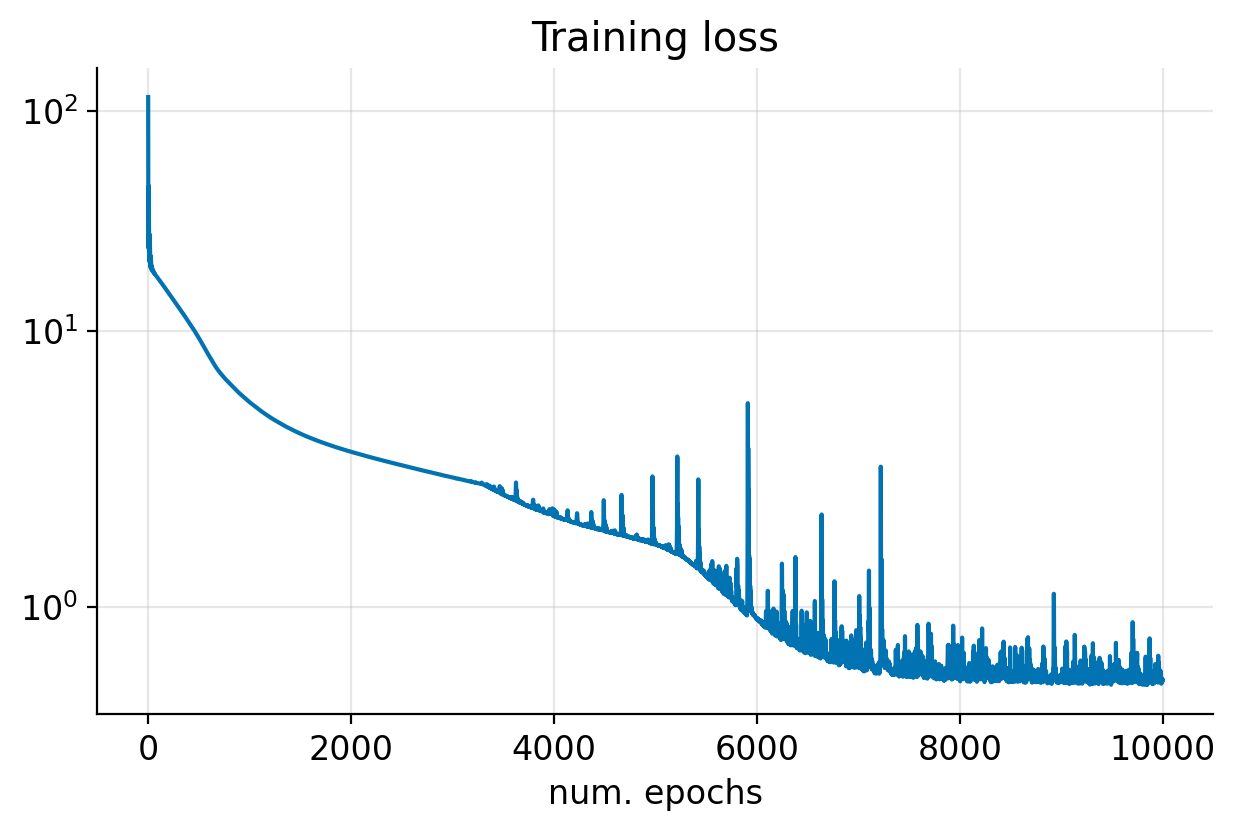

In [37]:
plt.plot(losses)
plt.yscale("symlog")
plt.title("Training loss")
plt.xlabel("num. epochs")
plt.grid(alpha=0.3)

## Posterior predictive

In [38]:
res = vbll.apply(state_final.params, xrange[:, None])
y_test_predictive = res.predictive
y_test_mu = y_test_predictive.mean
y_test_sigma = jnp.sqrt(y_test_predictive.covariance_diagonal)

In [39]:
lbound = y_test_mu - 2 * y_test_sigma
ubound = y_test_mu + 2 * y_test_sigma

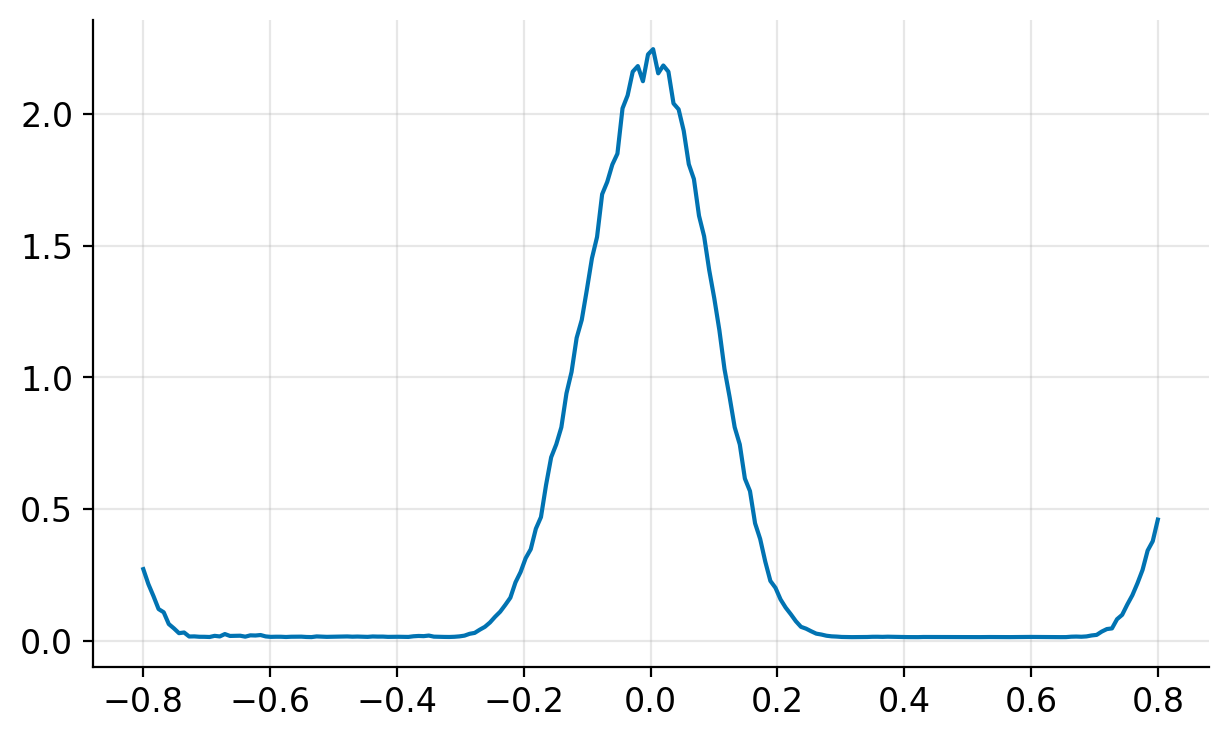

In [40]:
plt.plot(xrange, y_test_predictive.covariance_diagonal)
plt.grid(alpha=0.3)

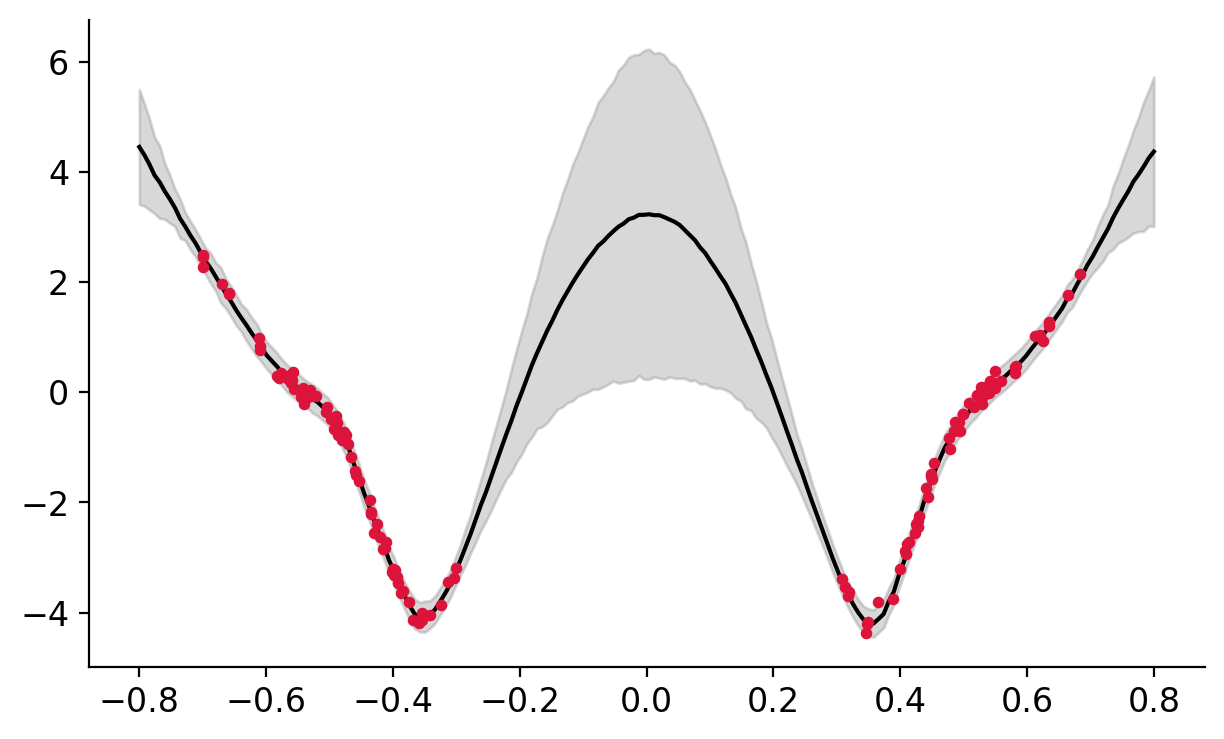

In [41]:
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)
plt.plot(xrange, y_test_mu, color="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)

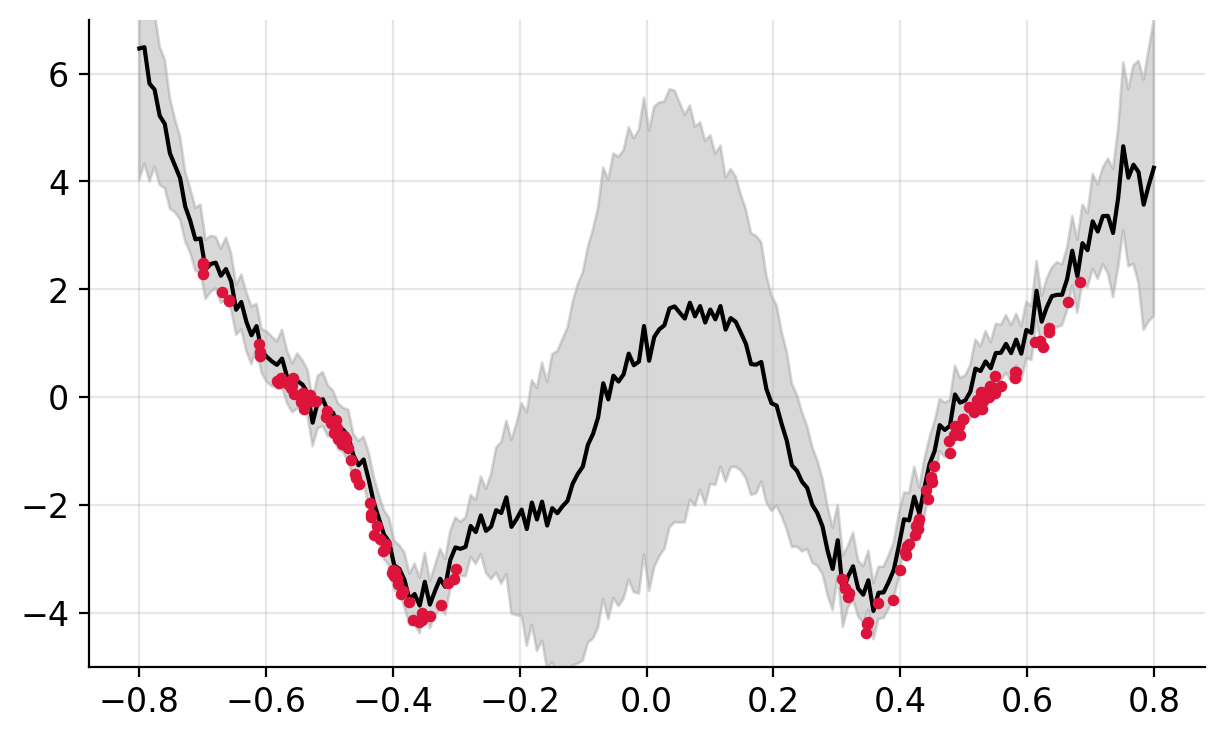

In [14]:
pvar_x = jnp.sqrt(ppvar(xrange[:, None]).squeeze())
pmean_x = agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]).squeeze()

plt.fill_between(xrange, pmean_x - 2 * pvar_x, pmean_x + 2  *  pvar_x, color="gray", alpha=0.3)
plt.plot(xrange, pmean_x, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.ylim(-5, 7)
plt.grid(alpha=0.3)